# Introduction

With the ever-increasing sophistication of cyber threats, traditional signature-based antivirus solutions are becoming less effective in detecting new and unknown malware variants. Machine learning offers a promising approach to address this challenge by leveraging advanced algorithms to analyze and classify malicious code automatically.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set the dark theme for plots
plt.style.use('dark_background')
# Suppress warnings
warnings.filterwarnings("ignore")


In [2]:
# Load the data
df = pd.read_csv("./data/malware.csv", delimiter="|")
df.head()

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,...,4,3.262823,2.568844,3.537939,8797.000000,216,18032,0,16,1
1,ose.exe,9d10f99a6712e28f8acd5641e3a7ea6b,332,224,3330,9,0,130560,19968,0,...,2,4.250461,3.420744,5.080177,837.000000,518,1156,72,18,1
2,setup.exe,4d92f518527353c0db88a70fddcfd390,332,224,3330,9,0,517120,621568,0,...,11,4.426324,2.846449,5.271813,31102.272727,104,270376,72,18,1
3,DW20.EXE,a41e524f8d45f0074fd07805ff0c9b12,332,224,258,9,0,585728,369152,0,...,10,4.364291,2.669314,6.400720,1457.000000,90,4264,72,18,1
4,dwtrig20.exe,c87e561258f2f8650cef999bf643a731,332,224,258,9,0,294912,247296,0,...,2,4.306100,3.421598,5.190603,1074.500000,849,1300,72,18,1


## Let's  do some EDA!

In [3]:
# Lets check of missing values
df.isnull().sum()

Name                           0
md5                            0
Machine                        0
SizeOfOptionalHeader           0
Characteristics                0
MajorLinkerVersion             0
MinorLinkerVersion             0
SizeOfCode                     0
SizeOfInitializedData          0
SizeOfUninitializedData        0
AddressOfEntryPoint            0
BaseOfCode                     0
BaseOfData                     0
ImageBase                      0
SectionAlignment               0
FileAlignment                  0
MajorOperatingSystemVersion    0
MinorOperatingSystemVersion    0
MajorImageVersion              0
MinorImageVersion              0
MajorSubsystemVersion          0
MinorSubsystemVersion          0
SizeOfImage                    0
SizeOfHeaders                  0
CheckSum                       0
Subsystem                      0
DllCharacteristics             0
SizeOfStackReserve             0
SizeOfStackCommit              0
SizeOfHeapReserve              0
SizeOfHeap

In [4]:
# There are no missing values in the dataset, GG!
# Lets check some information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138047 entries, 0 to 138046
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Name                         138047 non-null  object 
 1   md5                          138047 non-null  object 
 2   Machine                      138047 non-null  int64  
 3   SizeOfOptionalHeader         138047 non-null  int64  
 4   Characteristics              138047 non-null  int64  
 5   MajorLinkerVersion           138047 non-null  int64  
 6   MinorLinkerVersion           138047 non-null  int64  
 7   SizeOfCode                   138047 non-null  int64  
 8   SizeOfInitializedData        138047 non-null  int64  
 9   SizeOfUninitializedData      138047 non-null  int64  
 10  AddressOfEntryPoint          138047 non-null  int64  
 11  BaseOfCode                   138047 non-null  int64  
 12  BaseOfData                   138047 non-null  int64  
 13 

<Axes: xlabel='legitimate'>

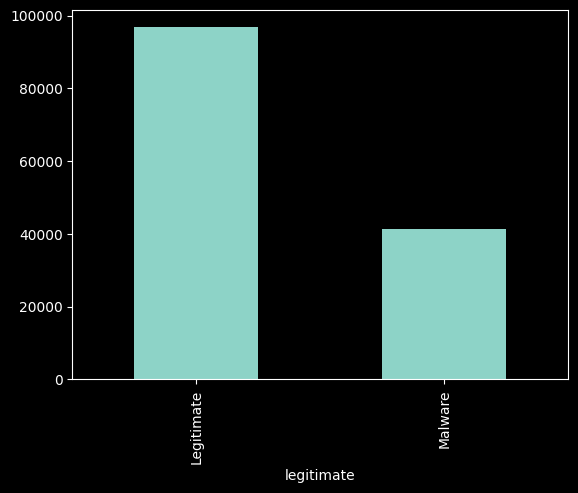

In [5]:
# Lets check the distribution of the target variable
df["legitimate"].replace({1: "Malware", 0: "Legitimate"}).value_counts().plot(kind='bar')
# Looks like the dataset is imbalanced, we will have to take care of this later

## Feature Selection and Model Building

In [6]:
# We can drop the string columns as they are not useful for our model
X = df.drop(columns=["Name", "md5", "legitimate"]).values
y = df["legitimate"].values

In [7]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=10)
X_new = selector.fit_transform(X, y)

selected_features = selector.get_support(indices=True)

print("Selected features:")
print(df.columns[selected_features])

Selected features:
Index(['MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode', 'BaseOfCode',
       'SizeOfImage', 'Subsystem', 'SizeOfHeapCommit', 'SectionsMaxEntropy',
       'ResourcesMeanSize', 'ResourcesMinSize'],
      dtype='object')


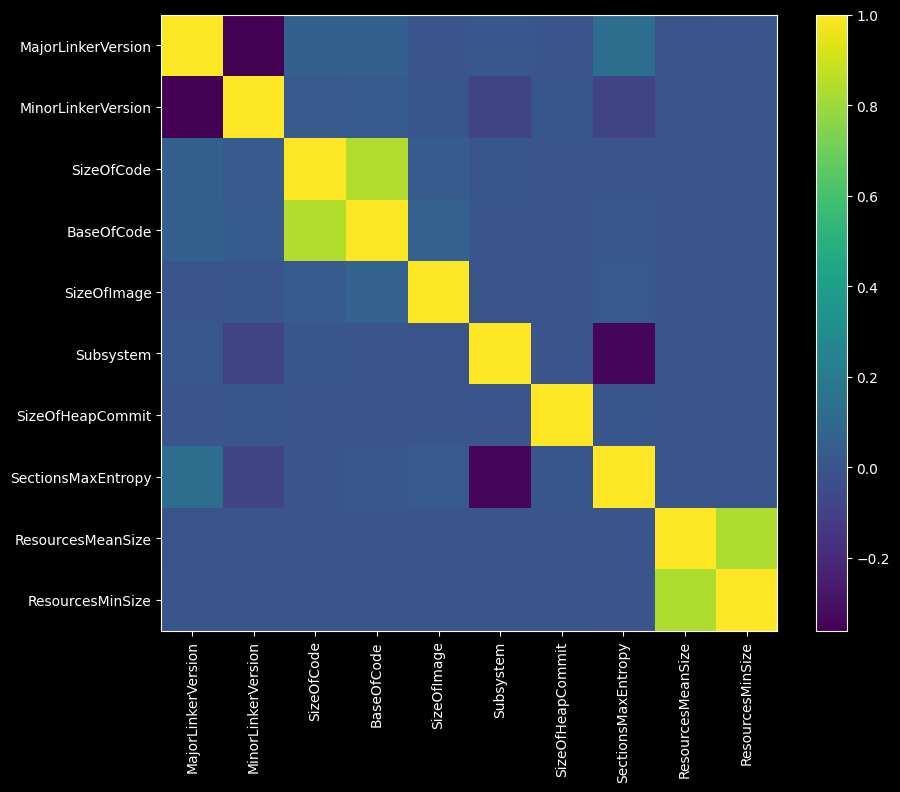

In [8]:
# Lets make a new dataframe with the selected features and check the corolation matrix
df_new = df[df.columns[selected_features]]
# Lets make a new dataframe with the selected features and check the correlation matrix
df_new = df[df.columns[selected_features]]

corr_matrix = df_new.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix)
plt.colorbar()

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

plt.show()


In [9]:
# Cool, now we can split the data into training and testing sets
from sklearn.model_selection import train_test_split

X = df_new.values
y = df["legitimate"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# We can take a few models and compare them

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "DecisionTree": DecisionTreeClassifier(max_depth=10),
}

In [21]:
results = {}
for algo in models:
    clf = models[algo]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("%s : %s " % (algo, score))
    results[algo] = score

Logistic Regression : 0.9255583725703248 
Random Forest : 0.9947603525292769 
DecisionTree : 0.9913557889653507 


Best model: Random Forest


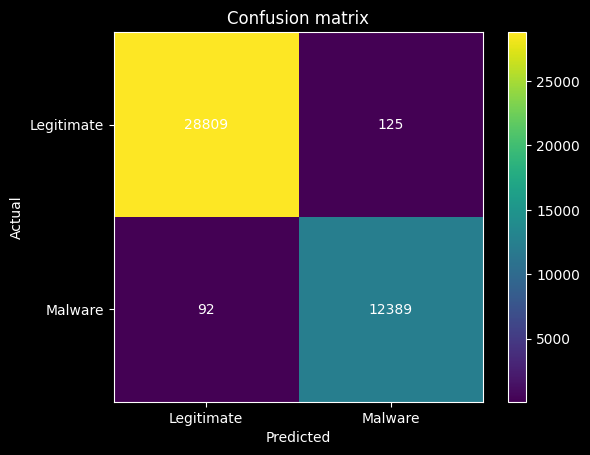

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28934
           1       0.99      0.99      0.99     12481

    accuracy                           0.99     41415
   macro avg       0.99      0.99      0.99     41415
weighted avg       0.99      0.99      0.99     41415



In [26]:
# Damn, the scores are too high, lets check the confusion matrix for random forest
from sklearn.metrics import confusion_matrix

best_model = max(results, key=results.get)
print(f"Best model: {best_model}")

clf = models[best_model]

y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.imshow(conf_matrix)
plt.colorbar()

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white')

plt.xticks(range(2), ["Legitimate", "Malware"])
plt.yticks(range(2), ["Legitimate", "Malware"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")
plt.show()

# Not bad, we can also check the classification report

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

In [13]:
import joblib
# Save the best model
joblib.dump(models[best_model], './model/best_model.pkl')


Best model: Random Forest


['./model/best_model.pkl']

## With that we are done, we can now use the model to predict if a file is malware or not, for that check the predict.py file